In [ ]:
import os
import numpy as np
import random
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50

2025-09-15 17:38:08.651185: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757957888.857804      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757957888.916306      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Reading Data

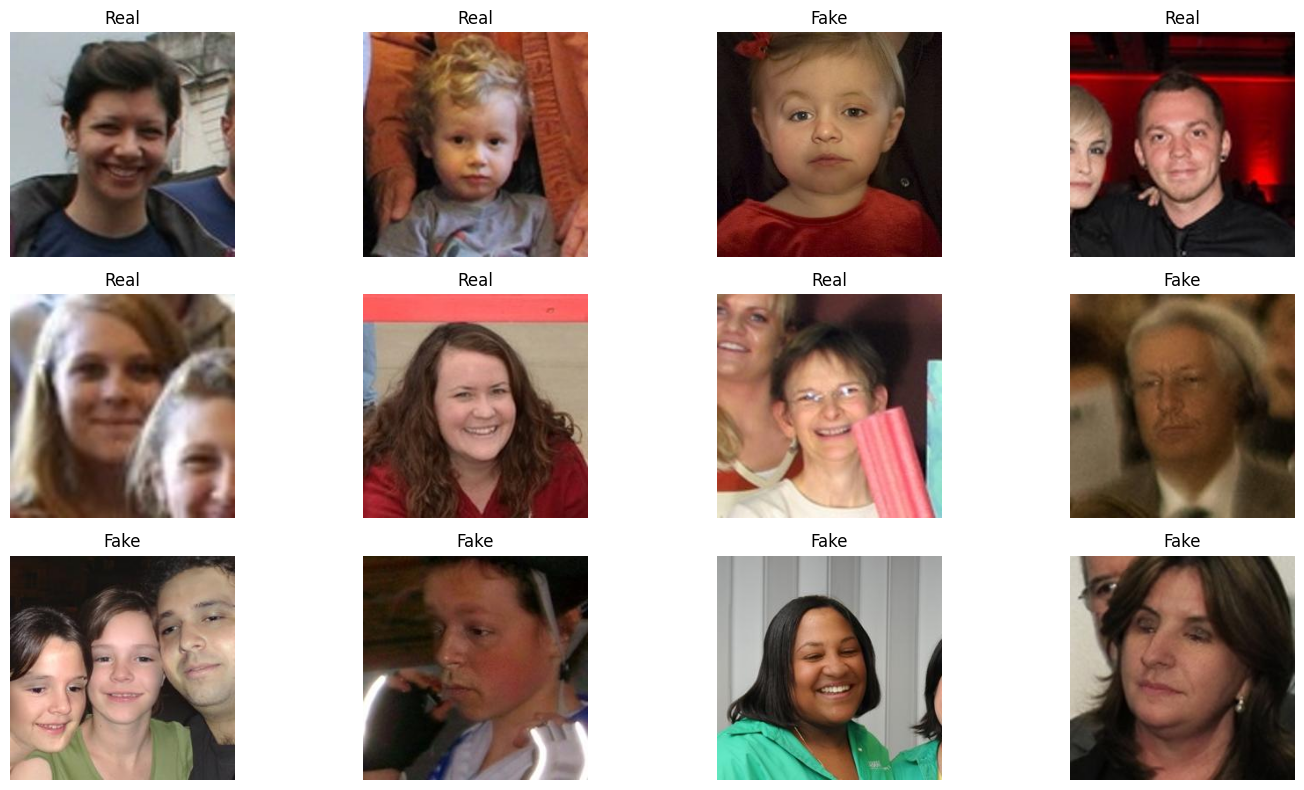

In [ ]:
fake_dir = "/kaggle/input/deepfake-and-real-images/Dataset/Train/Fake"
real_dir = "/kaggle/input/deepfake-and-real-images/Dataset/Train/Real"

fake_images = random.sample(os.listdir(fake_dir), 6)
real_images = random.sample(os.listdir(real_dir), 6)

all_images = [(os.path.join(fake_dir, f), "Fake") for f in fake_images] + \
             [(os.path.join(real_dir, r), "Real") for r in real_images]

random.shuffle(all_images)

plt.figure(figsize=(15, 8))
for i, (img_path, label) in enumerate(all_images):
    plt.subplot(3, 4, i+1)
    img = mpimg.imread(img_path)
    plt.imshow(img)
    plt.title(label)
    plt.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
train_data_gen = ImageDataGenerator(
    rescale = 1./255 ,
    horizontal_flip = True
)
data_gen = ImageDataGenerator( rescale = 1./255 )

In [ ]:
TARGET_SIZE = (256,256)
train_generator = train_data_gen.flow_from_directory(
    directory = "/kaggle/input/deepfake-and-real-images/Dataset/Train",
    class_mode = 'binary',
    target_size = TARGET_SIZE,
    batch_size = 32,
)

val_generator = data_gen.flow_from_directory(
    directory = "/kaggle/input/deepfake-and-real-images/Dataset/Validation",
    class_mode = 'binary',
    target_size = TARGET_SIZE,
    batch_size = 32,
    shuffle = False
)

test_generator = data_gen.flow_from_directory(
    directory = "/kaggle/input/deepfake-and-real-images/Dataset/Test",
    class_mode = 'binary',
    target_size = TARGET_SIZE,
    batch_size = 32,
    shuffle = False
)

Found 140002 images belonging to 2 classes.
Found 39428 images belonging to 2 classes.
Found 10905 images belonging to 2 classes.


# ResNet50 Model

In [ ]:
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(256, 256, 3))

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(1, activation='sigmoid')(x)

resnet_model = Model(inputs=base_model.input, outputs=x)

I0000 00:00:1757848722.489965      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [ ]:
model_checkpoint = ModelCheckpoint(
    'resnet_best_model.h5',
    monitor="val_accuracy",
    save_best_only=True,
    mode="max",
    verbose=1
)
early_stopping = EarlyStopping(monitor='val_accuracy',restore_best_weights=True, patience=5)

In [ ]:
resnet_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
resnet_history = resnet_model.fit(train_generator, epochs = 10, validation_data = val_generator , 
                    callbacks = [model_checkpoint, early_stopping] )

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


I0000 00:00:1757848802.046755     118 service.cc:148] XLA service 0x7f3034002150 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1757848802.047519     118 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1757848806.643237     118 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1757848828.106287     118 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


4376/4376 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.9179 - loss: 0.2041
Epoch 1: val_accuracy improved from -inf to 0.93248, saving model to resnet_best_model.h5
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 1707s 373ms/step - accuracy: 0.9179 - loss: 0.2041 - val_accuracy: 0.9325 - val_loss: 0.1646
Epoch 2/10
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 0.9596 - loss: 0.1031
Epoch 2: val_accuracy did not improve from 0.93248
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 911s 208ms/step - accuracy: 0.9596 - loss: 0.1031 - val_accuracy: 0.8293 - val_loss: 0.4062
Epoch 3/10
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 0.9710 - loss: 0.0734
Epoch 3: val_accuracy did not improve from 0.93248
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 947s 216ms/step - accuracy: 0.9710 - loss: 0.0733 - val_accuracy: 0.8495 - val_loss: 0.3706
Epoch 4/10
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 0.9773 - loss: 0.0576
Epoch 4: val_accuracy did not improve from 0.93248
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 912s 20

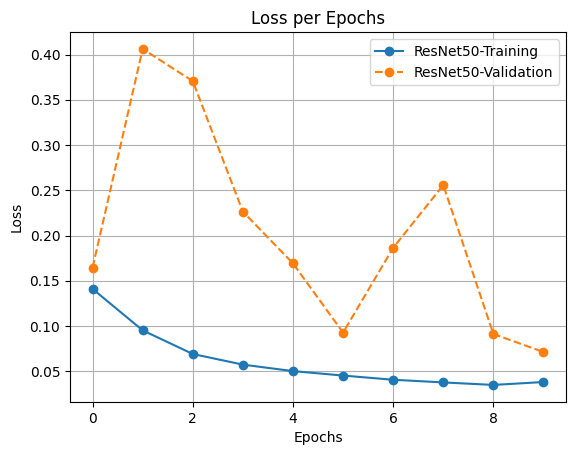

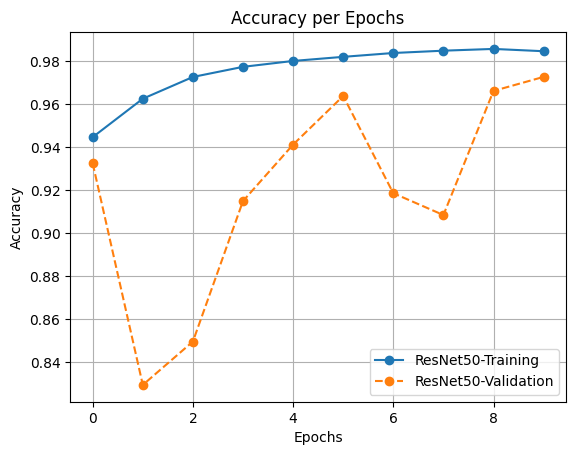

In [ ]:
plt.plot(resnet_history.history['loss'], label='ResNet50-Training', marker='o')
plt.plot(resnet_history.history['val_loss'], label='ResNet50-Validation',linestyle='--', marker='o')
plt.title('Loss per Epochs') 
plt.xlabel('Epochs') 
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()


plt.plot(resnet_history.history['accuracy'], label='ResNet50-Training', marker='o')
plt.plot(resnet_history.history['val_accuracy'], label='ResNet50-Validation',linestyle='--', marker='o')
plt.title('Accuracy per Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

In [5]:
test_loss, test_accuracy = resnet_model.evaluate(test_generator)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1757958123.526140     120 service.cc:148] XLA service 0x7ab64c04c0f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1757958123.527123     120 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1757958124.280399     120 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/341 ━━━━━━━━━━━━━━━━━━━━ 20s 62ms/step - accuracy: 0.9688 - loss: 0.0570 

I0000 00:00:1757958128.153989     120 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


341/341 ━━━━━━━━━━━━━━━━━━━━ 96s 251ms/step - accuracy: 0.9506 - loss: 0.1307
Test Loss: 0.23858541250228882
Test Accuracy: 91.55%


341/341 ━━━━━━━━━━━━━━━━━━━━ 110s 310ms/step


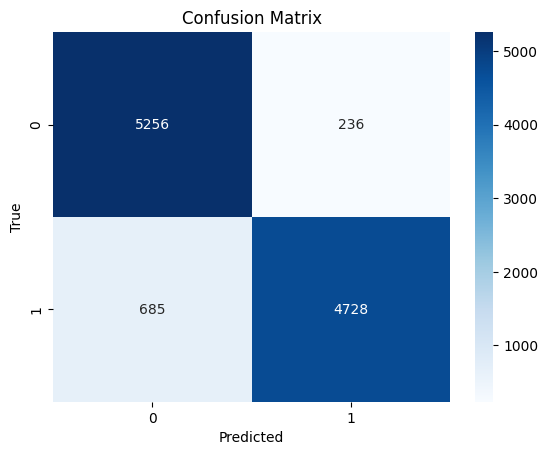

              precision    recall  f1-score   support

        Fake       0.88      0.96      0.92      5492
        Real       0.95      0.87      0.91      5413

    accuracy                           0.92     10905
   macro avg       0.92      0.92      0.92     10905
weighted avg       0.92      0.92      0.92     10905



In [ ]:
y_true = test_generator.classes

y_pred_prob = resnet_model.predict(test_generator)
y_pred = (y_pred_prob > 0.5).astype(int).ravel()

cm = confusion_matrix(y_true, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_true, y_pred, target_names = test_generator.class_indices.keys()))

341/341 ━━━━━━━━━━━━━━━━━━━━ 31s 79ms/step


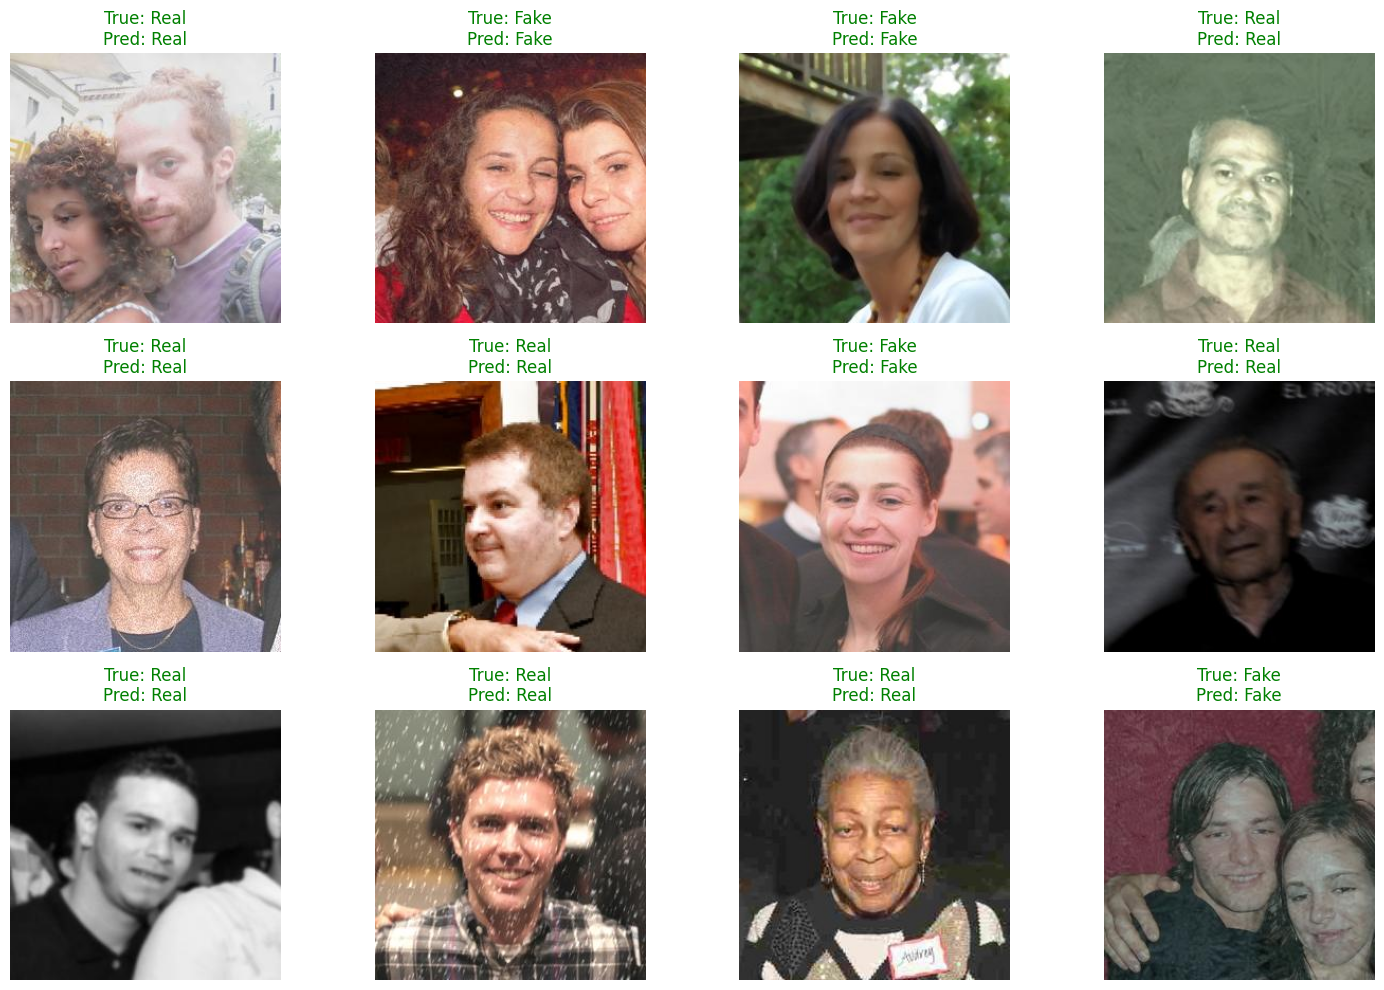

In [ ]:
test_generator.reset()  # Reset generator so predictions align with labels

y_true = test_generator.classes
y_pred_prob = resnet_model.predict(test_generator, verbose=1)
y_pred = (y_pred_prob > 0.5).astype(int).ravel()

class_names = list(test_generator.class_indices.keys())

indices = np.random.choice(len(y_true), size=12, replace=False)

plt.figure(figsize=(15, 10))
for i, idx in enumerate(indices):
    img_path = test_generator.filepaths[idx]  
    img = plt.imread(img_path)

    plt.subplot(3, 4, i+1)
    plt.imshow(img.astype("uint8"))
    
    true_label = class_names[y_true[idx]]
    pred_label = class_names[y_pred[idx]]
    
    # Title shows True vs Pred
    color = "green" if true_label == pred_label else "red"
    plt.title(f"True: {true_label}\nPred: {pred_label}", color=color)
    plt.axis("off")

plt.tight_layout()
plt.show()
